# BERT Weather Condition Custom Training and Sentiment Analysis Evaluation

Import the necessary libraries and packages. Pandas for the dataframe and in-memory data management. Numpy for linear algebra, wordcloud and matplotlib for visualization.

In [6]:
! pip install seaborn
! pip install wordcloud
! pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 7.2/7.2 MB 50.9 MB/s eta 0:00:00
     -------------------------------------- 307.0/307.0 KB 9.3 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=e4cc392524a8715848bae14bce34656bc6bb37b6ef0a0e4e24102f13c34a65fe
  Stored in directory: c:\users\kamran\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import os
import time
import logging

Import and read the data into a pandas dataframe

In [8]:
path = "daily_weather_2020.csv" # path to data csv
if(os.path.exists(path)):
    print("File Found")
    df = pd.read_csv(path, usecols=['summary', 'icon'], low_memory=True, dtype=str, encoding="utf-8")
else:
    print("no file found")

File Found


# Data Cleaning and Validation setup

Replace the icon column of the dataframe and check all the data was loaded properly as expected. The icon column items are replaced with the proper sentiment instead of the current icon value. This will help with validation when training the data. The entire dataset has validation.

In [9]:
# Print the dataframe basic information
df = df.rename(columns={'summary':'statement', 'icon': 'sentiment'})
df.info()
# Set up the validation column in the dataframe without modifying the raw data
def setValidation():
    print("SETTING UP DATA VALIDATION")
    for i in range(len(df.sentiment)):
        val = df.sentiment[i]
        if val == 'rain' or val == 'snow' or val == 'wind' or val == 'fog':
            df.sentiment[i] = 'negative' # negative sentiment
        elif val == 'clear-day':
            df.sentiment[i] = 'positive' # positive sentiment
        elif val == 'partly-cloudy-day' or val == 'cloudy':
            df.sentiment[i] = 'neutral' # neutral (possibly not enough data)
    print("VALIDATION HAS BEEN SET UP")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30688 entries, 0 to 30687
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  30685 non-null  object
 1   sentiment  30688 non-null  object
dtypes: object(2)
memory usage: 479.6+ KB


The validation that is setup can be tested by running the snippet below. This is a time consuming and resource intensive step, so it is not recommended to run this when reusing the same dataset.

In [10]:
# check the validation edit worked
def checkValidationSetting():
    print("CHECKING VALIDATION DATA")
    favorable_count = 0
    unfavorable_count = 0
    neutral_count = 0

    for i in range(len(df.sentiment)):
        if(df.sentiment[i] == 'positive'):
            favorable_count +=1
        elif(df.sentiment[i] == 'negative'):
            unfavorable_count +=1
        elif(df.sentiment[i] == 'neutral'):
            neutral_count +=1

    print('Favorable Count: ' + str(favorable_count))
    print('Unfavorable Count: ' + str(unfavorable_count))
    print('Neutral Count: ' + str(neutral_count))


start = time.time()
setValidation()
checkValidationSetting()
print('==PROCESS COMPLETED==\n', time.time()-start, 'seconds')


SETTING UP DATA VALIDATION
VALIDATION HAS BEEN SET UP
CHECKING VALIDATION DATA
Favorable Count: 8527
Unfavorable Count: 12904
Neutral Count: 9257
==PROCESS COMPLETED==
 4.6366050243377686 seconds


# Data Visualization
The input data is visualized here to validate the efficacy of the dataset and the expected parameters. Wordcloud visualization was thought to not be an efficient visualization because specific words do not matter, we are testing for overall sentiment using a variety of key words, some will not appear in real world data. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30688 entries, 0 to 30687
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  30685 non-null  object
 1   sentiment  30688 non-null  object
dtypes: object(2)
memory usage: 479.6+ KB


c:\users\kamran\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


negative    12904
neutral      9257
positive     8527
Name: sentiment, dtype: int64

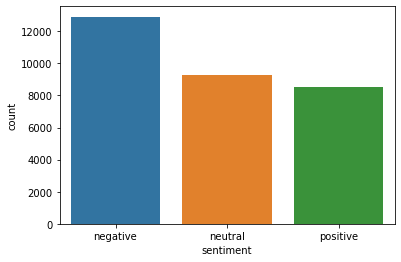

In [11]:
df.describe()
df.info()

sns.countplot(df.sentiment)

df['sentiment'].value_counts()

# Custom Tokenization
Custom tokenization is needed to add weight to named entities and numerical values. Because named entities and numerical values are inherently more data rich, they should have greater weight in the word vector of the input phrase, thus custom tokenization is required. Input phrases are tokenized based on number of named entities, numerical values, length, and any sentimental key phrases.

Necessary tokenization modules are imported first and setup

# Test and Train DataFrames

In [12]:
train,eval = train_test_split(df,test_size=0.1)

# SimpleTransformers Model Setup and Build

The BERT model is setup here with the sentiment classifiers. The model segments into three classes by default. These three classes are mapped to condition sentiments in the dataframe for training validation. BERT Base-cased is the pretrain used to recognize and tokenize with weight on character casing, essential in understanding more of the data. 

In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch

# Logging for model
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_gpu = torch.cuda.is_available()

# Create a TransformerModel
model_args = ClassificationArgs(num_train_epochs=2,
                                reprocess_input_data=True,
                                overwrite_output_dir=True,
                                train_batch_size=1)
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args=model_args, use_cuda=True)

The default model outputs are overwritten here and replaced with the relevant condition sentiment

In [ ]:
# 0,1,2 : positive,negative,neutral
def making_label(st):
    if(st=='positive'):
        return 0
    elif(st=='neutral'):
        return 2
    else:
        return 1

train['label'] = train['sentiment'].apply(making_label)
eval['label'] = eval['sentiment'].apply(making_label)
print(train.shape)

The dataset is prepared for training via the creation of a test DataFrame and Evaluation DataFrame

In [ ]:
train_df = pd.DataFrame({
    'text': train['statement'][:27619],
    'label': train['label'][:27619]
})
train_df.columns = ["text", "labels"]

print(train_df)

eval_df = pd.DataFrame({
    'text': eval['statement'][-3069:],
    'label': eval['label'][-3069:]
})
eval_df.columns=["text", "labels"]
print(eval_df)

The DataFrames are then run through testing and new result variables are created for evaluating model metrics

In [ ]:
puystart = time.time()
model.train_model(train_df, eval_df=eval_df)
print('TRAINING TIME:', time.time()-start)
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

# Transformers Model Build and Setup


Install the transformers package containing BERT and its necessary sublibraries. It also builds wheels for runtime and loads the models into runtime with the given models and tokenizers. 

In [13]:
! pip install transformers

     ---------------------------------------- 3.8/3.8 MB 15.3 MB/s eta 0:00:00
     ------------------------------------- 274.4/274.4 KB 16.5 MB/s eta 0:00:00
     ---------------------------------------- 67.0/67.0 KB ? eta 0:00:00
     ---------------------------------------- 3.2/3.2 MB 25.7 MB/s eta 0:00:00
     ------------------------------------- 895.2/895.2 KB 28.5 MB/s eta 0:00:00
     ---------------------------------------- 155.4/155.4 KB ? eta 0:00:00


In [14]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## Data Formatting and Refactoring

Replace sentiments with numerical class representations for tensors.

In [15]:
df.describe()
df.info()

# Set up the validation column in the dataframe without modifying the raw data
def setValidation():
    print("REFACTORING SENTIMENTS")
    for i in range(len(df.sentiment)):
        val = df.sentiment[i]
        if val == 'negative':
            df.sentiment[i] = 1 # negative sentiment
        elif val == 'positive':
            df.sentiment[i] = 0 # positive sentiment
        elif val == 'neutral':
            df.sentiment[i] = 2 # neutral (possibly not enough data)
    print("SENTIMENTS REFACTORED")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30688 entries, 0 to 30687
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  30685 non-null  object
 1   sentiment  30688 non-null  object
dtypes: object(2)
memory usage: 479.6+ KB


Visualize the modified data and determine if the refactoring was applied correctly.

c:\users\kamran\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

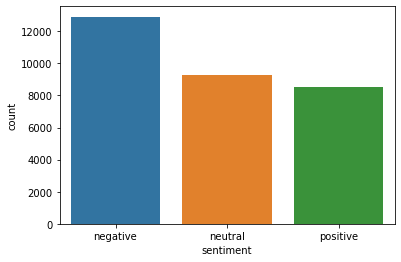

In [16]:
sns.countplot(df.sentiment)

Define an example for the model, prevents discrepencies in data pulling.

In [17]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

## Begin data tensorfication and loading classes

# Model Metrics and Model Performance

SciKit is used to validate the model and test how the model performs when trained with this dataset. Anything above 90% is enough for the model to be considered useful and accurate.

In [18]:
print(result)
print(model_outputs)

lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = eval_df['labels'].tolist()
predicted = lst

NameError: name 'result' is not defined

In [19]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
print(mat)

df_cm = pd.DataFrame(mat, range(3), range(3))

sns.heatmap(df_cm, annot=True)
plt.show()
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

sklearn.metrics.classification_report(true,predicted,target_names=['positive','neutral','negative'])
print('Model Accuracy: ', 100*sklearn.metrics.accuracy_score(true,predicted), '%')

NameError: name 'true' is not defined

# Live Demo and Model Testing
This function allows for the model to be evaluated with manually prompted data, a user interface for evaluating the model with real time and human generated queries.

In [ ]:
def get_result(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'positive',1:'negative',2:'neutral'}
    print(sentiment_dict[pos])
    return

sentiment = get_result(input("Input a phrase for Validation: "))
print("The input data was classified as:", sentiment)